In [2]:
import sys
sys.path.append("../")

In [3]:
import libs.AudioDataSet
import torchaudio.transforms as transforms
import torch
import matplotlib.pyplot as plt
import librosa
import hashlib
from scipy.ndimage.filters import maximum_filter, gaussian_filter
from scipy.ndimage.morphology import (generate_binary_structure, iterate_structure, binary_erosion)

In [4]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1,figsize=(12,8))
    axs.set_title(None)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram),cmap="gray", origin="lower", aspect="auto")
    plt.show(block=False)
    axs.axes.get_xaxis().set_visible(False)
    axs.axes.get_yaxis().set_visible(False)
    axs.set_frame_on(False)
    axs.set_xlabel(None)
    axs.set_ylabel(None)

In [5]:
dataSet = libs.AudioDataSet.AudioDataset("../data/compressed_index/")

In [6]:
audio = dataSet[0]


In [7]:
audio_2 = dataSet[1]

In [8]:
audio_slice = audio[:,300000:600000]

In [9]:
from moviepy.audio.AudioClip import AudioArrayClip
audio1 = AudioArrayClip(audio.T, fps=5512*2)
audio2 = AudioArrayClip(audio_slice.T, fps=5512*2)

audio1.write_audiofile('test_1.wav')
audio2.write_audiofile('test_2.wav')

MoviePy - Writing audio in test_1.wav


chunk:   0%|          | 0/4509 [00:00<?, ?it/s, now=None]

MoviePy - Done.
MoviePy - Writing audio in test_2.wav


MoviePy - Done.


In [10]:
audio3 = AudioArrayClip(audio_2.T, fps=5512*2)
audio3.write_audiofile('test_3.wav')

MoviePy - Writing audio in test_3.wav


MoviePy - Done.


In [11]:
#Получает карту созвездий (как шазам)
def constellation_hash(peaks, neighbor_size=7):
    # peaks are fq x time
    peak_indices = torch.nonzero(peaks)
    
    for i in range(peak_indices.shape[0]):
        anchor = peak_indices[i]
        for j in range(1, min(neighbor_size, peak_indices.shape[0] - i)):
            # hash is: fq of anchor | fq of neighbor | neighbor.time - anchor.time
            neighbor = peak_indices[i+j]
            delta = neighbor[1] - anchor[1]
            if delta < 20:
                continue
            seq = f"{anchor[0]}|{neighbor[0]}|{delta}"
            h = hashlib.md5(seq.encode('utf-8'))
            # return (hash(seq), anchor.time)
            yield (h.hexdigest()[0:20], int(anchor[1]))

In [12]:
from datasketch import MinHash, MinHashLSH, MinHashLSHEnsemble, MinHashLSHForest

In [13]:
lsh = MinHashLSH(threshold=0.5, num_perm=128)
def minhash(peaks,name=""):
  minhashes = []
  nonzero = peaks.nonzero()
  
  # delta_time = nonzero[0][1]
  # m = MinHash(num_perm=128)
  # for peak in nonzero:
  #   if peak[1] - delta_time > 10:
  #     minhashes.append(m)
  #     lsh.insert(name+"_"+str(delta_time), m)
  #     m.clear()
  #     delta_time = peak[1]
  #   m.update(str(peak).encode('utf-8'))
  return minhashes

In [14]:
# Получает пики
def get_peaks(samples):
  spec = transforms.Spectrogram(n_fft=1024, hop_length=256)(torch.from_numpy(samples))
  struct = generate_binary_structure(2, 1)
  neighborhood = iterate_structure(struct, 7)
  dilated = maximum_filter(spec[0],footprint=neighborhood, size=10)
  peaks = torch.abs(torch.from_numpy(dilated) - spec[0])
  peaks = torch.where(peaks == 0, 1, 0)
  background = binary_erosion(gaussian_filter(torch.abs(spec[0]), sigma=10), structure=neighborhood)
  erosed_peaks = peaks * background
  return erosed_peaks

In [15]:
def fingerprint(samples,name=""):
    spec = transforms.Spectrogram(n_fft=1024, hop_length=256)(torch.from_numpy(samples))
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, 7)
    dilated = maximum_filter(spec[0],footprint=neighborhood, size=10)
    peaks = torch.abs(torch.from_numpy(dilated) - spec[0])
    peaks = torch.where(peaks == 0, 1, 0)
    background = binary_erosion(gaussian_filter(torch.abs(spec[0]), sigma=10), structure=neighborhood)
    erosed_peaks = peaks * background
    return minhash(erosed_peaks,name=name)
    # return  constellation_hash(erosed_peaks,neighbor_size=7)

In [ ]:
def hanna_spectrogram(samples):
  spec = librosa.stft(samples, n_fft=2048, hop_length=64, window="hann",)

In [33]:
from scipy import signal 
import numpy as np

def create_log_spectrogram(samples):
  S_scale = transforms.Spectrogram(n_fft=2048, hop_length=64)(torch.from_numpy(samples))
  Y_scale = torch.abs(S_scale)**2
  Y_log_scale = transforms.AmplitudeToDB(stype="power")(Y_scale)
  return Y_log_scale

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, ax = plt.subplots(5,4, figsize=(8, 2))
    print(ax)
    for i in range(5):
      for j in range(4):
        ax[i][j].axis("off")
        librosa.display.specshow(specgram[:,i*3*128+j*128:(j+1)*128+i*3*128],sr=5512,hop_length=64,cmap="gray", y_axis="log",bins_per_octave=32,x_axis="time",ax=ax[i][j])

In [17]:
def test(samples):
  C = np.abs(librosa.cqt(sr=5512, y=samples,fmin=20, hop_length=64, n_bins=32, bins_per_octave=32))
  return C

In [18]:
audio_slice.shape

(1, 300000)

In [19]:
#32 log-bins in 318-2000 Hz range
def filter(S_db,minFreq=318,maxFreq=2000):
  return S_db[:,minFreq:maxFreq,:]

In [34]:
specc1 = create_log_spectrogram(audio)



# plt.imshow(librosa.display.specshow(specc[0].numpy(),y_axis='log',x_axis='time'))

In [42]:
from scipy import interpolate

In [60]:
arr = specc1[0].numpy()

old_indices = np.arange(arr.shape[0])

(1025, 140901)


ValueError: cannot reshape array of size 144423525 into shape (32,140901)

(1025,) (1025,) (1025, 1025) (1025, 1025)


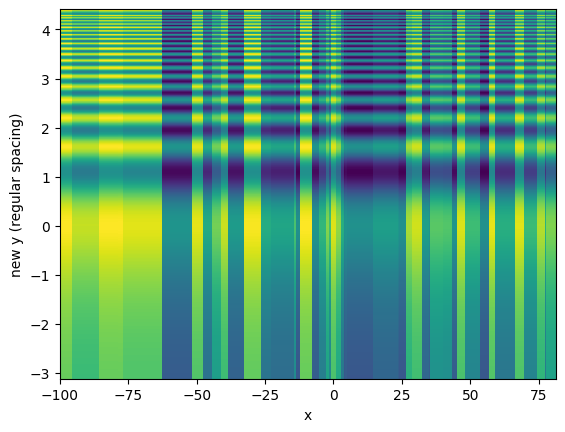

In [58]:
# Interpolation of the transformed data on a regular new y axis
ylog_interpolation = interpolate.interp1d(np.log(y), z_grid.T)
new_y = np.linspace(min(np.log(y)), max(np.log(y)), len(y))
new_z_grid = ylog_interpolation(new_y).T

print(x.shape, y.shape, z_grid.shape, new_z_grid.shape)

# axis
plt.pcolormesh(x, new_y, new_z_grid);
plt.xlabel('x'); plt.ylabel('new y (regular spacing)');

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

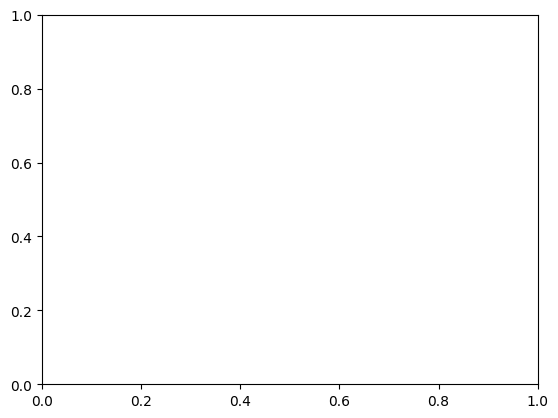

In [55]:
plt.pcolormesh(x, np.log(y), z_grid)
plt.xlabel('x'); plt.ylabel('log(y) (non regular spacing)')

In [41]:
arr = specc1[0].numpy()
ylog_interpolation =  interpolate.interp1d(np.arange(arr.shape[0]), arr,)

RuntimeError: shape '[32, 140901]' is invalid for input of size 144423525

In [ ]:
specc = create_log_spectrogram(audio_slice)
specc= filter(specc)


In [ ]:
specc1 = test(audio)
specc = test(audio_slice)


In [ ]:
specc2 = test(audio_2)

In [ ]:
import pywt

def getTopWavelet(img):
  coeffs2 = pywt.dwt2(img, 'haar')
  LL, (LH, HL, HH) = coeffs2
  # plt.imshow(img, cmap='gray'), plt.show()
  LL = np.where(LL >= np.sort(LL.flatten())[-200], 1, 0)
  LH = np.where(LH >= np.sort(LH.flatten())[-200], 1, 0)
  HL = np.where(HL >= np.sort(HL.flatten())[-200], 1, 0)
  HH = np.where(HH >= np.sort(HH.flatten())[-200], 1, 0)
  img = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
  img = np.where(img >= np.sort(img.flatten())[-200], 1, 0)
  # plt.imshow(img, cmap='gray'), plt.show()
  return img




In [ ]:
p = getTopWavelet(specc1[0,:,256:384])

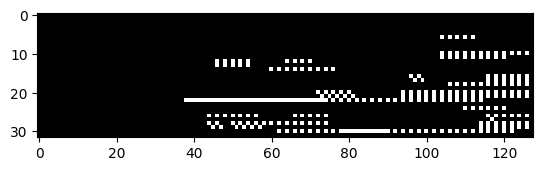

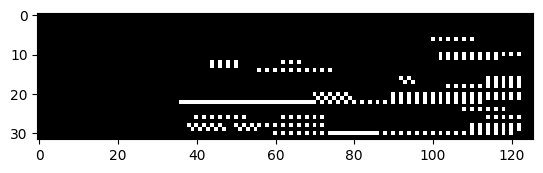

In [ ]:

j = getTopWavelet(specc[0,:,259:384])
plt.imshow(p, cmap='gray')
plt.show()
plt.imshow(j, cmap='gray')
#1.48sec

In [ ]:
fingerprints = []
for i in range(0,specc1.shape[2],128):
  fingerprints.append(getTopWavelet(specc1[0,:,i:i+128]).flatten())
len(fingerprints)

1101

In [ ]:
fingerprints2 = []
for i in range(0,specc.shape[2],128):
  fingerprints2.append(getTopWavelet(specc[0,:,i:i+128]).flatten())
len(fingerprints2)

37

In [ ]:
fingerprints3 = []
for i in range(0,specc2.shape[2],128):
  fingerprints3.append(getTopWavelet(specc2[0,:,i:i+128]).flatten())
len(fingerprints3)

1029

In [ ]:
m = MinHash(num_perm=25)


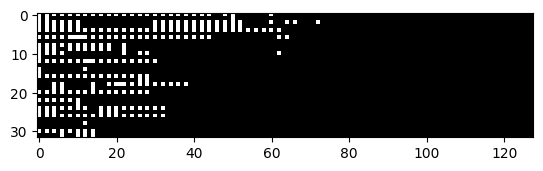

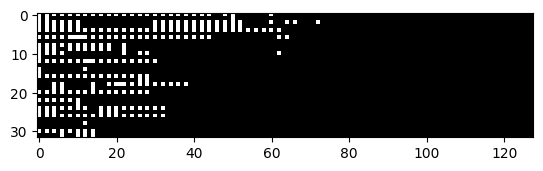

In [ ]:
plt.imshow(fingerprints[1].reshape(32,128), cmap='gray')
plt.show()
plt.imshow(fingerprints2[1].reshape(32,128), cmap='gray')

In [ ]:
fingerprints[0]

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from scipy import stats
import random
import sklearn.metrics as skm

In [ ]:
class MinHash3:
  def __init__(self, min_hashes):
    self.min_hash_size = min_hashes
    self.min_hashes = []
    self.createMinHashSeeds()
  
  def lshHash(data,seedOne,seedTwo):
    hash = int(66)
    hash = hash * 15 ^ seedOne
    hash = hash * 15 ^ seedTwo
    hash = hash * 15 ^ data
    return hash

  def createMinHashSeeds(self):
    skipDuplicates = set()
    i = 0
    while i < self.min_hash_size:
      seed = (random.randint(1, 1000), random.randint(1, 1000))
      if seed not in skipDuplicates:
        self.min_hashes.append(seed)
        skipDuplicates.add(seed)
        i += 1
      

  def getMinHashSignature(self,array,signature_size):
    signature = np.array([0xFFFFFFFF] * signature_size)
    skipDuplicates = set()
    for r,row in enumerate(array):
      if(r not in skipDuplicates):
        for i in range(signature_size):
          seeds = self.min_hashes[i]
          current_hash = MinHash3.lshHash(row,seeds[0],seeds[1])
          if current_hash < signature[i]:
            signature[i] = current_hash
    return signature

In [ ]:
def generate_hash_functions(num_hashes):
    hs = []
    for i in range(num_hashes):
      a = random.randint(1, 555555)
      b = random.randint(0, 555555)
      # print(f"{a}x + {b} mod 5")
      def h(x):
        return (a * x + b) % num_hashes
      hs.append(h)
    return hs
def h1(x):
  return x%5

def h2(x):
  return (2*x+1)%5

def minHash2(arrays,num_hashes):
  
  hashes = generate_hash_functions(num_hashes)
  signatures = np.array([[0xFFFFFFFF] * len(arrays[0]) for _ in range(num_hashes)])


  # for r,row in enumerate(arrays):
  #   for h,hash in enumerate(hashes):
  #     hash_val = hash(r)
  #     for c,col in enumerate(row):
  #       if col == 1 and signatures[h][r] > hash_val:
  #         signatures[h][r] = hash_val
  
  for i,row in enumerate(arrays):
    hash_values = []
    for h,hash in enumerate(hashes):
      hash_values.append(hash(i+1))
    
    indices = np.nonzero(row)
    for j in indices[0]:
      for h,val in enumerate(hash_values):
        if signatures[h][j] > val:
          signatures[h][j] = val
    
  return signatures
    
  

In [ ]:
def minHASH(arrays, num_perm):
  permutations = []
  count = 0
  while count < num_perm:
    perm = random.sample(range(0, len(arrays[0])), len(arrays[0]))
    if(stats.entropy(perm) > 2):
      # print(skm.mutual_info_score(arrays[0], perm))
      permutations.append(perm)
      count += 1
    
  signatures = []
  for i in range(len(arrays)):
    signature = []
    for permutation in permutations:
      for j in permutation:
        if(arrays[i][j] == 1):
          signature.append(j)
          break
    signatures.append(signature)
  return signatures
      

In [ ]:
def split_signature(signature, bands):
  assert len(signature) % bands == 0
  r = len(signature) // bands
  return [signature[i:i + r] for i in range(0, len(signature), r)]

In [ ]:
def jaccard_index(p, q):
  intersect = sum(x and y for x, y in zip(p, q))
  union = sum(x or y for x, y in zip(p, q))
  if union == 0:
    print(0)
  else:
    print(intersect / union)

In [ ]:
((12332321*1 + 33)%999983)%11

6

In [ ]:
import numpy as np
import random
import struct
import hashlib
import numpy as np
 




def jaccard_sim(X, Y):
    """Jaccard similarity between two sets"""
    x = set(X)
    y = set(Y)
    return float(len(x & y)) / len(x | y)

def jaccard_similarity(signature1, signature2):
    """
    Compute the Jaccard similarity between two MinHash signatures.

    Parameters:
    signature1 (numpy array): MinHash signature of shape (num_hashes,)
    signature2 (numpy array): MinHash signature of shape (num_hashes,)

    Returns:
    similarity (float): Jaccard similarity between the two signatures
    """
    intersection = np.sum(np.bitwise_and(signature1, signature2))
    union = np.sum(np.bitwise_or(signature1, signature2))
    return intersection / union


# Example usage
arr1 = np.array([1,0,1,1,0])
arr2 = np.array([1,1,1,0,1])




# mh1= MinHash(d = 100)

# mh1.add(arr1)
# mh1.add(arr2)

# # print(mh1.jaccard(mh2),"JACCARD")

# num_hashes = 100
# print(mh1.hashvalues)
# print(mh1.hashvalues)
# real_sim = jaccard_similarity(arr1, arr2)
# similarity = jaccard_sim(mh1.hashvalues, mh1.hashvalues)
# print("Real Jaccard similarity:", real_sim)
# print("Jaccard similarity:", similarity)

In [ ]:
np.concatenate([np.where(arr1 == 0)[0],np.where(arr1 == 1)[0]]).astype(int)

array([ 1,  3,  4,  5,  7,  8,  9, 10, 11,  0,  2,  6])

In [ ]:
minH = MinHash3(100)
# arr11 = np.concatenate([np.where(arr1 == 0)[0],np.where(arr1 == 1)[0]]).astype(int)
# arr22 = np.concatenate([np.where(arr2 == 0)[0],np.where(arr2 == 1)[0]]).astype(int)
signatures = []
for f in fingerprints:
  signatures.append(minH.getMinHashSignature(f,100))
# signatures = [minH.getMinHashSignature(arr1,100),minH.getMinHashSignature(arr2,100)]
print(jaccard_similarity(fingerprints[0],fingerprints[1]))
# print(signatures[0],signatures[1])
print(jaccard_similarity(signatures[0],signatures[1]))


0.188
1.0


In [ ]:
jaccard_similarity(fingerprints[0],fingerprints2[0])

1.0

In [ ]:
for i,f in enumerate(fingerprints[:-1]):
  for j,s in enumerate(fingerprints2[:-1]):
    if(jaccard_similarity(f,s) > 0.35):
      print(i,j,jaccard_similarity(f,s))

0 0 1.0
1 1 1.0
2 2 1.0
3 3 1.0
4 4 1.0
5 5 1.0
6 6 1.0
7 7 1.0
8 8 1.0
9 9 1.0
10 10 1.0
11 11 1.0
12 12 1.0
13 13 1.0
14 14 1.0
15 15 1.0
16 16 1.0
17 17 1.0
18 18 1.0
19 19 1.0
20 20 1.0
21 21 1.0
22 22 1.0
23 23 1.0
24 24 1.0
25 25 1.0
26 26 1.0
27 27 1.0
28 28 1.0
29 29 1.0
30 30 1.0
31 31 1.0
32 32 1.0
33 33 1.0
34 34 1.0
35 35 0.9781818181818182
1096 1 0.4314214463840399
1099 1 0.3788546255506608


In [ ]:
print(np.stack(fingerprints[:-1]).shape)

(1100, 4096)


In [ ]:
print(np.stack(fingerprints2[:-1]).shape)

(36, 4096)


In [ ]:
fingerprints3

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 1, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 1, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0,

In [ ]:
np.concatenate((fingerprints[:-1],fingerprints2[:-1],fingerprints3[:-1])).shape

(2164, 4096)

In [ ]:
# hashFunctions = gHashFunctions(100,arr1.size).
# signatures = minHash2(np.stack(fingerprints[:-1]).T, 100)
# print(signatures.T[0],signatures.T[1])
signatures = minHASH(np.concatenate((fingerprints[:-1],fingerprints2[:-1],fingerprints3[:-1])), 100)
s1 = signatures[:1100]
s2 = signatures[1100:1136]
s3 = signatures[1136:]
# print(jaccard_similarity(arr1,arr2))
# print(jaccard_similarity(signatures[1],signatures[1096]))
# print(jaccard_similarity(sign[0],sign[1]))


In [ ]:
m = {}
for i,p in enumerate(s2):
  for j,q in enumerate(s3):
    jaccard = jaccard_similarity(p,q)
    if jaccard > 0.7:
      if i in m and m[i][1] < jaccard:
        m[i] = [j,jaccard]
      else:
        m[i] = [j,jaccard]
coord = np.array([
  [i,j[0],j[1]] for i,j in m.items()
])


In [ ]:
m

{0: [1027, 0.722990513557819],
 2: [1008, 0.7097457321072079],
 9: [1027, 0.7270729467331409],
 15: [1022, 0.7011826057142225],
 20: [1022, 0.7006594397580176],
 29: [1027, 0.7078273844626267],
 34: [968, 0.70307472808036]}

In [ ]:
coord[:,0]

array([  19,   20,   22,  135,  176,  244,  250,  379,  388,  391,  451,
        486,  629,  694,  720,  724,  761,  801,  825,  877,  999, 1046])

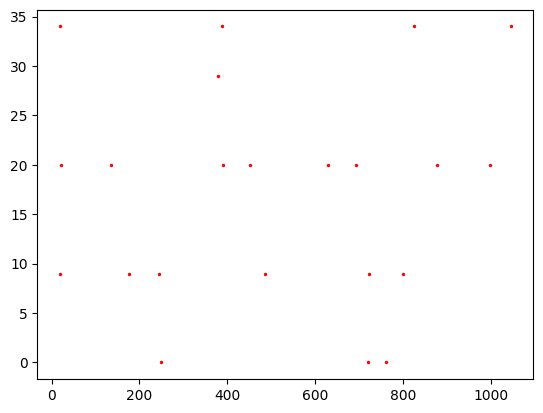

In [ ]:
import itertools

plt.scatter(coord[:,0], coord[:,1],s=2, color='red')
plt.show()

In [ ]:
m = {}
for j,s in enumerate(fingerprints2[:-1]):
  for i,f in enumerate(fingerprints[:-1]):
    if j in m and m[j][1] < jaccard_similarity(f,s):
      m[j] = (f'Search sec: {j*1.48 if j*1.48 < 60 else j*1.48/60} \n Target sec: {i*1.48 if i*1.48 < 60 else i*1.48/60}',jaccard_similarity(f,s))
    else:
      m[j] = (f'Search sec: {j*1.48 if j*1.48 < 60 else j*1.48/60} \n Target sec: {i*1.48 if i*1.48 < 60 else i*1.48/60}',jaccard_similarity(f,s))
print(m)

{0: ('Search sec: 0.0 \n Target sec: 27.108666666666668', 0.22348484848484848), 1: ('Search sec: 1.48 \n Target sec: 27.108666666666668', 0.3788546255506608), 2: ('Search sec: 2.96 \n Target sec: 27.108666666666668', 0.006568144499178982), 3: ('Search sec: 4.4399999999999995 \n Target sec: 27.108666666666668', 0.23473282442748092), 4: ('Search sec: 5.92 \n Target sec: 27.108666666666668', 0.031825795644891124), 5: ('Search sec: 7.4 \n Target sec: 27.108666666666668', 0.08865248226950355), 6: ('Search sec: 8.879999999999999 \n Target sec: 27.108666666666668', 0.055658627087198514), 7: ('Search sec: 10.36 \n Target sec: 27.108666666666668', 0.17227722772277226), 8: ('Search sec: 11.84 \n Target sec: 27.108666666666668', 0.11171171171171171), 9: ('Search sec: 13.32 \n Target sec: 27.108666666666668', 0.07452339688041594), 10: ('Search sec: 14.8 \n Target sec: 27.108666666666668', 0.12027491408934708), 11: ('Search sec: 16.28 \n Target sec: 27.108666666666668', 0.08602150537634409), 12: ('

In [ ]:

p = [[1,0,1,0,0,0,1,0,0,0,0,0],[1,0,1,0,1,0,1,0,0,0,1,1],[1,0,1,0,0,0,1,0,0,0,0,1]]
q = [[1,0,1,0,0,0,1,0,0,0,0,0],[1,0,1,1,1,0,0,0,0,0,1,1],[1,0,0,0,0,0,0,1,1,0,0,1]]

min_hash_p = minHASH(p, 100)
min_hash_q = minHASH(q, 100)

m_p = MinHash(num_perm=100)
m_q = MinHash(num_perm=100)

for i in p:
  m_p.update(str(i).encode('utf-8'))

for i in q:
  m_q.update(str(i).encode('utf-8'))
jaccard_index(min_hash_p, min_hash_q)
print(m_p.jaccard(m_q))
  


bands_p = split_signature(min_hash_p, 25)
bands_q = split_signature(min_hash_q, 25)

TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [ ]:
np.nonzero(np.random.permutation(fingerprints[0]))[0][0]

12

In [ ]:
mh_a = MinHash(num_perm=100)
mh_b = MinHash(num_perm=100)

    
jaccard_index(p, q)
jaccard_index(minHASH(p, 400), minHASH(q, 400))

for i in fingerprints[0]:
  mh_a.update(i)

for i in fingerprints[1000]:
  mh_b.update(i)
  
sum(mh_a.digest()), sum(mh_b.digest()),fingerprints[0].sum(), fingerprints[1000].sum()

NameError: name 'MinHash' is not defined

In [ ]:
lsh = MinHashLSHForest(num_perm=100)
minhashes = {}
for c,f in enumerate(fingerprints):
  m = MinHash(num_perm=100)
  zero = np.where(f == 0)[0]
  one = np.where(f == 1)[0]
  for i in zero:
    m.update(str(i).encode('utf-8'))
  for i in one:
    m.update(str(i).encode('utf-8'))
  lsh.add(c, m)
  minhashes[c] = m
lsh.index()

In [ ]:
fingerprints2 = []
for i in range(0,specc.shape[2],128):
  fingerprints2.append(getTopWavelet(specc[0,:,i:i+128]).flatten())
minhashes2 = {}
for c,f in enumerate(fingerprints2):
  m = MinHash(num_perm=100)
  zero = np.where(f == 0)[0]
  one = np.where(f == 1)[0]
  for i in zero:
    m.update(str(i).encode('utf-8'))
  for i in one:
    m.update(str(i).encode('utf-8'))
  # lsh.insert(c, m)
  minhashes2[c] = m



In [ ]:
result = lsh.query(minhashes2[0],10)
print(result)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
count = 0
for key, value in minhashes2.items():
  query = lsh.query(value,3)
  if len(query) > 0 :
    print(key,query)
    

0 [0, 1, 2]
1 [0, 1, 2]
2 [0, 1, 2]
3 [0, 1, 2]
4 [0, 1, 2]
5 [0, 1, 2]
6 [0, 1, 2]
7 [0, 1, 2]
8 [0, 1, 2]
9 [0, 1, 2]
10 [0, 1, 2]
11 [0, 1, 2]
12 [0, 1, 2]
13 [0, 1, 2]
14 [0, 1, 2]
15 [0, 1, 2]
16 [0, 1, 2]
17 [0, 1, 2]
18 [0, 1, 2]
19 [0, 1, 2]
20 [0, 1, 2]
21 [0, 1, 2]
22 [0, 1, 2]
23 [0, 1, 2]
24 [0, 1, 2]
25 [0, 1, 2]
26 [0, 1, 2]
27 [0, 1, 2]
28 [0, 1, 2]
29 [0, 1, 2]
30 [0, 1, 2]
31 [0, 1, 2]
32 [0, 1, 2]
33 [0, 1, 2]
34 [0, 1, 2]
35 [0, 1, 2]
36 [0, 1, 2]
37 [0, 1, 2]
38 [0, 1, 2]
39 [0, 1, 2]
40 [0, 1, 2]
41 [0, 1, 2]
42 [0, 1, 2]
43 [0, 1, 2]
44 [0, 1, 2]
45 [0, 1, 2]
46 [0, 1, 2]
47 [0, 1, 2]
48 [0, 1, 1100]


In [ ]:
for k,m in minhashes2.items():
  for k2,n in minhashes.items():
    if m.jaccard(n) > 0.53 and m.jaccard(n) < 0.83:
      print(k,k2,m.jaccard(n))

In [ ]:
specc1.shape

(1, 32, 140901)

In [ ]:
fin = specc.unfold(0,128,64)

AttributeError: 'numpy.ndarray' object has no attribute 'unfold'

In [ ]:
fin.shape

torch.Size([10, 10157, 128])

In [ ]:
full = fingerprint(audio,"full")
slice = fingerprint(audio_slice,"slice")

In [ ]:
keys = lsh.hashtables

In [ ]:
slice_peaks = get_peaks(audio_slice)
audio_peaks = get_peaks(audio)

In [ ]:
slice_peaks.shape

torch.Size([513, 2540])

In [ ]:

def get_minhashes(peaks,sr=1024,hop=256):
  step = sr//hop
  non_zero_secs = []
  for a in range(0,peaks.shape[1],step):
    non_zero_secs.append(peaks[:,a:a+step].nonzero())
  minhashes = []
  for sec,fq_time in enumerate(non_zero_secs):
    m = MinHash(num_perm=64)
    for pq in fq_time:
      m.update(str(pq).encode('utf-8'))
    minhashes.append(m)
    m.clear()
  return minhashes



In [ ]:
lsh = MinHashLSH(threshold=0.5, num_perm=64)
full_M = get_minhashes(audio_peaks)
for sec,m in enumerate(full_M):
  if m.count()>0:
    lsh.insert(f"full_{sec}", m)

In [ ]:



set1 = set(['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'datasets'])
set2 = set(['minhash', 'is', 'a', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])
set3 = set(['minhash', 'is', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])

target = MinHash(num_perm=128)
lsh = MinHashLSH(threshold=0.5, num_perm=128)
for d in set1:
    target.update(d.encode('utf8'))
m = MinHash(num_perm=128)
for d in set2:
    m.update(d.encode('utf8'))
lsh.insert("m2", m)
m.clear()
for d in set3:
    m.update(d.encode('utf8'))
lsh.insert("m3", m)
result = lsh.query(target)
print("Approximate neighbours with Jaccard similarity > 0.5", result)

Approximate neighbours with Jaccard similarity > 0.5 ['m2', 'm3']


dict_keys([b'\x00\x00\x00\x00\xb7^\x1a\x99\x00\x00\x00\x00L>\xbf_\x00\x00\x00\x00i\x82\x08\xce\x00\x00\x00\x00\xe4S^\x85\x00\x00\x00\x00`\xba$\x05', b'\x00\x00\x00\x00\'\xa6\xbf\xfb\x00\x00\x00\x00\xf7\x85\xd8\xb3\x00\x00\x00\x00#h\xfd\x85\x00\x00\x00\x00\xf2\xefc\x1e\x00\x00\x00\x00\x80"U~', b'\x00\x00\x00\x00\xfe\xec\xdc\xe1\x00\x00\x00\x00o\x8c\xb6@\x00\x00\x00\x00L\x90\xa5\xe4\x00\x00\x00\x00\xcf\x07\xec\xb8\x00\x00\x00\x00\x0f\x80u=', b'\x00\x00\x00\x00%\x05&\xeb\x00\x00\x00\x00\xe6\x86u5\x00\x00\x00\x00\x9f0\xbd\xfb\x00\x00\x00\x00\xc7&\xc3\xbc\x00\x00\x00\x00\xc3\x1bWE', b'\x00\x00\x00\x00\x94\x18\xc5\xc2\x00\x00\x00\x00\x8f\x17a\xcb\x00\x00\x00\x00\xa3\x92\xbf\t\x00\x00\x00\x00\xfb\xd5\x7f\xf4\x00\x00\x00\x00\xb2`\xcfK', b'\x00\x00\x00\x00q\xfdb)\x00\x00\x00\x00\x8f\x00\x17\x99\x00\x00\x00\x00P\xaf1j\x00\x00\x00\x00\xdd\x06;@\x00\x00\x00\x00\xbd\xfd\x98\xa4', b'\x00\x00\x00\x00\xea\xf2\xb2f\x00\x00\x00\x00\xf7\x9c\xe3y\x00\x00\x00\x00#\xfe\xf8f\x00\x00\x00\x00\x08\x16\x82g\x00\

In [ ]:
full_map = dict(full)
slice_map = dict(slice)
st = set(full_map.keys()).intersection(set(slice_map.keys()))

TypeError: 'MinHash' object is not iterable

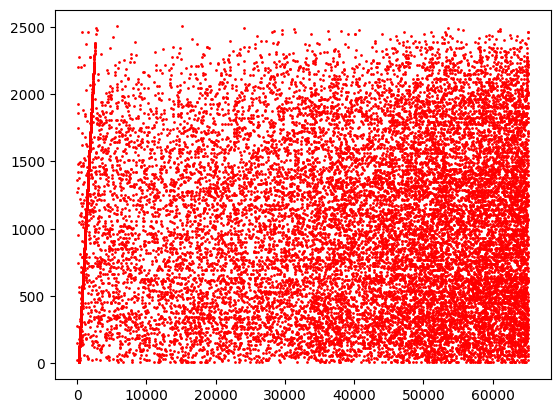

In [ ]:
array_full = []
array_slice = []
for key in st:
  array_full.append(full_map[key])
  array_slice.append(slice_map[key])
plt.scatter(array_full, array_slice,s=1, color='red')
plt.show()